In [1]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from scipy import signal
from scipy import stats
from scipy import linalg

import sys
sys.path.insert(0,'..')
import specsens as ss

In [2]:
length = 1.0 # in seconds

wbs = ss.WidebandSignal(t_sec=length, num_bands=10, num_steps=10)

mat = np.array([[-100, -100, -100, -100, -100, -100, -100,   10, -100,    0],
                [   0, -100, -100, -100, -100, -100, -100,   10,   10,    0],
                [   0,    0, -100, -100, -100, -100, -100, -100,   10,    0],
                [   0, -100, -100, -100, -100,   10, -100, -100,   10, -100],
                [-100, -100, -100, -100, -100,   10, -100, -100, -100,    5],
                [-100, -100, -100, -100, -100,   10, -100, -100, -100,    5],
                [   0, -100,   10, -100, -100,   10, -100, -100, -100,    5],
                [-100, -100,   10, -100, -100,   10, -100,    5, -100,    5],
                [   0, -100,   10, -100, -100, -100, -100,    5, -100, -100],
                [-100, -100, -100, -100, -100, -100, -100,    5, -100, -100]])

# mat = np.array([[-100, -100, -100, -100, -100, -100, -100, -100, -100, -100],
#                 [-100, -100, -100, -100, -100, 10, -100, -100, -100, -100]])

# mat = np.array([[-10, -100, -100, -100, -100, -100, -100, -100, -100, -100],
#                 [10, -100, -100, -100, -100, 10, -100, -100, -100, -100]])

sig, sample_freq = wbs.get_signal(mat)

wgn = ss.WhiteGaussianNoise(f_sample=sample_freq, t_sec=length)
noise = wgn.get_signal(dB=0.)

assert wbs.num_samples == wgn.num_samples
num_samples = wbs.num_samples

both = sig + noise

Created WidebandSignal with 1.0 MHz total bandwidth and 10000 samples per step


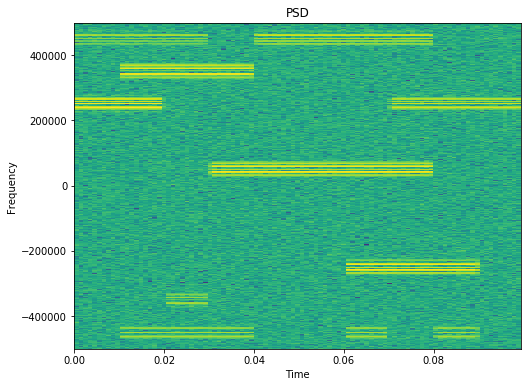

In [3]:
# Plot the resulting signals using matplotlib

# plt.figure(figsize=(8, 6))
# plt.specgram(noise,
#              NFFT=1024,
#              Fs=sample_freq,
#              scale='dB',
#              cmap='viridis',
#              noverlap=0,
#              mode='psd',
#              window=signal.get_window('hann', 1024))
# plt.title("PSD")
# plt.xlabel("Time")
# plt.ylabel("Frequency")
# plt.show()

# plt.figure(figsize=(8, 6))
# plt.specgram(sig,
#              NFFT=1024,
#              Fs=sample_freq,
#              scale='dB',
#              cmap='viridis',
#              noverlap=0,
#              mode='psd',
#              window=signal.get_window('hann', 1024))
# plt.title("PSD")
# plt.xlabel("Time")
# plt.ylabel("Frequency")
# plt.show()

plt.figure(figsize=(8, 6))
plt.specgram(both,
             NFFT=1024,
             Fs=sample_freq,
             scale='dB',
             cmap='viridis',
             noverlap=0,
             mode='psd',
             window=signal.get_window('hann', 1024))
plt.title("PSD")
plt.xlabel("Time")
plt.ylabel("Frequency")
plt.show()

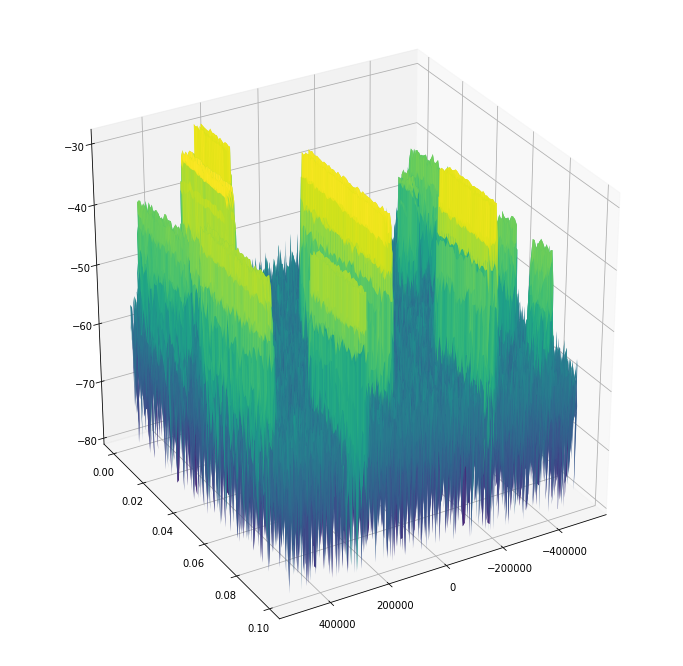

In [5]:
from scipy import fft
import scipy.ndimage
from mpl_toolkits import mplot3d as mpl3d
from matplotlib import cm

f, t, Sxx = signal.spectrogram(both,
                               sample_freq,
                               return_onesided=False,
                               window='hann',
                               nperseg=1024,
                               nfft=1024,
                               noverlap=0,
                               detrend=False,
                               scaling='density',
                               mode='psd')

f = fft.fftshift(f)
Sxx = fft.fftshift(Sxx, axes=0)

def clip_2d(x, lim_min, lim_max):
    (x, y) = np.shape(Sxx)
    for i in range(x):
        for j in range(y):
            Sxx[i, j] = max(min(Sxx[i, j], lim_max), lim_min)
    return Sxx


def smooth_2d(x, sigma):
    return scipy.ndimage.filters.gaussian_filter(x, [sigma, sigma],
                                                 mode='mirror')


def crop_2d(Sxx, f, t, n):
    Sxx = Sxx[n:-n, n:-n]
    f = f[n:-n]
    t = t[n:-n]
    return Sxx, f, t

Sxx = 10.0 * np.log10(Sxx)
Sxx = clip_2d(Sxx, -80, 0)
# Sxx = smooth_2d(Sxx, 2)
# Sxx, f, t = crop_2d(Sxx, f, t, 4)

fig = plt.figure(figsize=(12, 12))
ax = fig.gca(projection='3d')
# ax.get_proj = lambda: np.dot(mpl3d.axes3d.Axes3D.get_proj(ax), np.diag([1, 1, 0.5, 1]))
ax.plot_surface(f[:, None],
                t[None, :],
                Sxx,
                cmap='viridis',
                rstride=1,
                cstride=1,
                alpha=1,
                antialiased=True)
ax.view_init(elev=30, azim=60)
plt.show()
# plt.savefig('test.png')

In [ ]:
# print(np.abs(sig[int(len(sig)/2-1)]))

l = len(sig)
print(f'sig len {l}')

n = int(len(sig)*1)
print(f'sec len {n}')
sec = np.abs(sig[(len(sig)-n)//2:(len(sig)+n)//2])
# print(f'sec {sec}')
print(f'sec len {len(sec)}')
    
left = np.mean(sec[0:len(sec)//2])
right = np.mean(sec[len(sec)//2:-1])
diff = right-left
print(f'diff {diff}')

x = np.linspace(0, len(sec)-1, len(sec))
log = stats.logistic.cdf(x, len(sec)/2-.5, len(sec)*1./15.) * diff + left
fac = log/sec
sec_corr = sec * fac

plt.figure(figsize=(8, 6))
plt.plot(x, sec, 'kx')
plt.plot(x, sec_corr, 'rx')
# plt.plot(x, log)
plt.plot(x, fac)
plt.show()

sig2 = np.copy(sig)
# sig2[(len(sig2)-n)//2:(len(sig2)+n)//2] *= fac

# plt.figure(figsize=(8, 6))
# plt.plot(np.abs(sig2[(len(sig2)-n)//2:(len(sig2)+n)//2]), 'kx')
# plt.show()

# plt.figure(figsize=(8, 6))
# plt.plot(np.abs(sig2), 'kx')
# plt.show()